## Results

In [149]:
import os
import re
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import random
import pickle


#from PIL import Image
#!pip install mat73
import mat73
import helper

#import cv2

import tensorflow as tf

import tensorflow.keras as keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns

import matplotlib.pyplot as plt

In [12]:
resize = 0.2

Retrieve the saved files, particularly those where we stored the performance metrics

In [3]:
### Retrieve performance files
result_files = os.listdir(f'resize_{resize}/')
performances_files = [file for file in result_files if 'performance' in file]

### We will store performances here
performances = dict()

### Retrieve performance for each file
for file in performances_files:
    with open(f'resize_{resize}/' + file, 'r') as f:
        performance = eval(f.read())        
        performances[file.replace('_performance.txt', '')] = {'F1 score' : performance['F1 score'],
                                                              'Accuracy' : performance['Accuracy']}        

These are the results in descending order

In [4]:
performances_df = pd.DataFrame(performances).transpose()

performances_df.sort_values(by = ['F1 score', 'Accuracy'], ascending = False)

,F1 score,Accuracy
Adam_v1,0.9523,0.9525
ker_3_stride_1,0.9509,0.9508
Adam_learningrate_00075_epsilon_1e-07_beta_1_0.8_beta_2_0.899,0.9475,0.9475
Adam_learningrate_0007,0.9475,0.9475
Adam_v4,0.9441,0.9443
Adam_learningrate_00075,0.9409,0.9410
prueba_adam,0.9357,0.9361
vgg16_trained1,0.9357,0.9361
ker_9_stride_2,0.9341,0.9344
Adam_learningrate_00075_epsilon_1e-07_beta_1_0.5_beta_2_0.599,0.9333,0.9328


So, we take the top 10 and observe what  characterizes them

In [156]:
top_10 = performances_df.sort_values(by = ['F1 score', 'Accuracy'], ascending = False).head(10)

#### Note:
This part was discarded since certain _extended_summary_ files could not be read by the _eval_ function, yet we leave the code in case we decide to use it for the _summary_ files or something else.

In [56]:
# def get_match(models, file):
    
#     """
#         Check if any of the models string identifier matches with
#         the name of a file
#     """
    
#     for model in models:
        
#         if model in file:
#             return True
        
#     return False

In [57]:
# ### Get top 10
# top_10 = performances_df.sort_values(by = ['F1 score', 'Accuracy'], ascending = False).head(10).index.tolist()

# ### Retrieve the extended_summary file for each of the top 10 models
# ext_summary_files = [file for file in result_files if get_match(top_10, file) and 'extended_summary' in file]

In [71]:
# ### We will store summaries here
# ext_summaries = dict()

# ### Retrieve performance for each file
# for file in ext_summary_files:
#     with open(f'resize_{resize}/' + file, 'r') as f:
#         ext_summary = f.read()        
#         ext_summaries[file.replace('_extended_summary.txt', '')] = ext_summary          

## Accuracy by angle

#### Retrieve the clasification by angles file

We manually labeled the images with respect to the angle in which it was taken. This can be **frontal**, **lateral** or **superior**.

In [191]:
url='https://docs.google.com/spreadsheets/d/1UpqooAtkEW_MECp4_TErZ1l5nOCIuaSv/edit#gid=1785635275'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_excel(url)
df.set_index('id', inplace = True)
df.drop('Unnamed: 3',axis = 1, inplace = True)

In [26]:
df.sample(10)

,label,toma
id,,
2518,glioma,frontal
292,meningioma,frontal
1101,pituitary,frontal
1594,pituitary,frontal
2920,glioma,lateral
2833,glioma,lateral
1227,pituitary,lateral
657,meningioma,lateral
1030,pituitary,superior


In [199]:
pd.DataFrame(df.groupby(['label', 'toma']).size())

0
label      toma         
glioma     frontal   489
           lateral   423
           superior  498
meningioma frontal   231
           lateral   268
           superior  207
pituitary  frontal   321
           lateral   318
           superior  291

In [190]:
df[df['label'] == 'pituituary']['label'] = 'pituitary'

id
59    pituituary
Name: label, dtype: object

#### Loading our images

The following lines are taken from the _modeling.ipynb_ to load the dataset. 

In [13]:
### Load each file independently (to avoid memory overflows) and retriev PID
patient_ids_dict = dict()
label_ids_dict = dict()
shape_x_dict = dict()
shape_y_dict = dict()
image_dict = dict()

for file_number in range(1,3047):
    file = f'../data/brain-tumor-data-public/{file_number}.mat'
    data_dict = mat73.loadmat(file)
    patient_ids_dict[file_number] = data_dict['cjdata']['PID']
    label_ids_dict[file_number] = int(data_dict['cjdata']['label'])
    shape_x_dict[file_number] = data_dict['cjdata']['image'].shape[0]
    shape_y_dict[file_number] = data_dict['cjdata']['image'].shape[1]
    image_dict[file_number] = data_dict['cjdata']['image']

In [14]:
patient_ids = pd.Series(patient_ids_dict)
label_ids = pd.Series(label_ids_dict)
shape_x = pd.Series(shape_x_dict)
shape_y = pd.Series(shape_y_dict)
image = pd.Series(image_dict)

patients = pd.DataFrame({'pid':patient_ids, 'label':label_ids,
                         'x':shape_x, 'y':shape_y, 'image':image}, index=range(1, 3047))

In [15]:
patients['image'] = patients['image'].apply(lambda x : helper.imx_preproc(x, zero_up_to_one=True, resize=resize))
patients['image'] = patients['image'].apply(lambda x : x.astype('float32'))

We add the new column for the angle label:

In [34]:
patients['angle'] = df['toma']

And we perform the split, with the same random seed as we did for the model trainings.

In [203]:
random.seed(1234)

val_size = 0.2
test_size = 0.2
# Training set has 2436 images test set has 610 images 
train_set, test_set = train_test_split(patients, stratify=patients['label'], test_size=test_size)
# Training set has 1948 images, validation set has 488 images
train_set, val_set = train_test_split(train_set, stratify=train_set['label'], test_size=val_size)

In [ ]:
new_train_set_y = tf.one_hot(train_set_y, depth = 4)
new_train_set_y = np.array(new_train_set_y)[:,1:]

In [ ]:
new_val_set_y = tf.one_hot(val_set_y, depth = 4)
new_val_set_y = np.array(new_val_set_y)[:,1:]

#### model_id

In [210]:
model_id = ''

In [ ]:
batch_size = 64
IMG_H = int(round(512 * resize, 0))
IMG_W = int(round(512 * resize, 0))

optimizer = 'adam'

In [ ]:
CNN = Sequential([
    InputLayer(input_shape=(IMG_H, IMG_W, 1)),
#     InputLayer(input_shape=(IMG_H, IMG_W, 3)), # For 3 channels
    
    Conv2D(64, 9, activation='relu',strides=(5, 5)),
    MaxPool2D(),

    #Conv2D(64, 9, activation='relu'),
    #MaxPool2D(),

    #Conv2D(64, 5, activation='relu'),
    #MaxPool2D(),

    #Conv2D(64, 3, activation='relu'),
    #MaxPool2D(),

    Flatten(),
    Dense(512, activation='relu'),
#     Dense(1, activation='sigmoid')
    Dense(3, activation='softmax')
])

CNN.summary()

In [ ]:
# Compile: Define training parameters
CNN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
EPOCHS = 50
BATCHES = n_total_train//batch_size

### Following line overflows memory
fitted_model = CNN.fit(train_set_x, new_train_set_y, steps_per_epoch=BATCHES,
                       epochs=EPOCHS, validation_data=(val_set_x, new_val_set_y),
                      callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])

#### Recover best model ans predict for each angle

In [209]:
def get_train_val_test(angle):

    train_set_x = np.stack(train_set[train_set['angle'] == angle]['image'].values)
    train_set_y = np.array(train_set[train_set['angle'] == angle]['label'])

#     val_set_x = np.stack(val_set[val_set['angle'] == angle]['image'].values)
#     val_set_y = np.array(val_set[val_set['angle'] == angle]['label'])

    test_set_x = np.stack(test_set[test_set['angle'] == angle]['image'].values)
    test_set_y = np.array(test_set[test_set['angle'] == angle]['label'])
    
    return [(train_set_x, train_set_y, 'train'),
#             (val_set_x, val_set_y, 'validation'),
            (test_set_x, test_set_y, 'test')]

def get_cm_and_metrics(data_x, data_y, CNN):
    
    predictions = CNN.predict(data_x)
    predictions = predictions.argmax(1) + 1

    cm = confusion_matrix(data_y, predictions)
    f1 = f1_score(data_y, predictions, average='weighted')
    acc = accuracy_score(data_y, predictions)
    
    return {'cm' : cm, 'f1': f1, 'acc': acc}

def plot_cm_and_metrics(results, model_id):
    
    fig, axs = plt.subplots(len(results), 1, figsize = (8,16))

    for k, result in enumerate(results):
        
        cm, group_counts, group_percentages, labels = auxiliar(result)

        sns.heatmap(cm, annot=labels, fmt='',cmap='Blues', annot_kws = {'fontsize':14}, ax = axs[k])

        f1 = f"F1 : {np.round(100 * result['results']['f1'], 2)}%\n"
        acc = f"Accuracy : {np.round(100 * result['results']['acc'] , 2)}%\n"
        axs[k].set_title(f1 + acc, fontsize = 20);
        axs[k].set_ylabel(f"{result['kind']}", labelpad = 18, fontsize = 18)

        ## Ticket labels - List must be in alphabetical order
        axs[k].xaxis.set_ticklabels(['Meningioma','Glioma', 'Pituituary'], fontsize = 14)
        axs[k].yaxis.set_ticklabels(['True\nMeningioma','True\nGlioma', 'True\nPituituary'], fontsize = 14, rotation = 45)
    
    plt.subplots_adjust(hspace = 0.7)
    plt.suptitle(angle, fontsize = 28, y = 1.01)
    plt.savefig(f'../results/resize_{resize}/{model_id}_{angle}_comparison.png', bbox_inches = 'tight')
    
def auxiliar(result):
    cm = result['results']['cm']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         ((cm.transpose()/cm.sum(1)).transpose()).flatten()]    
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)
    
    return cm, group_counts, group_percentages, labels

def compare_angles(angle, model_id):
    
    datasets = get_train_val_test(angle) 
    results = [{'kind' : data[2], 'results': get_cm_and_metrics(data[0], data[1], CNN)} for data in datasets]
    plot_cm_and_metrics(results, model_id)

And we show the plots for all of the angles, for the selected model:

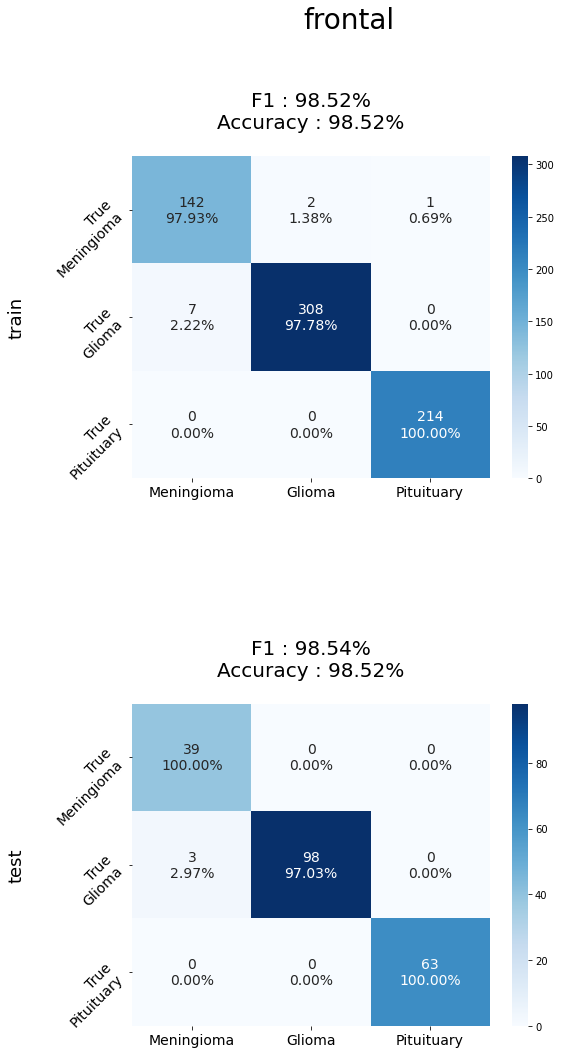

In [206]:
angle = 'frontal'
compare_angles(angle, model_id)

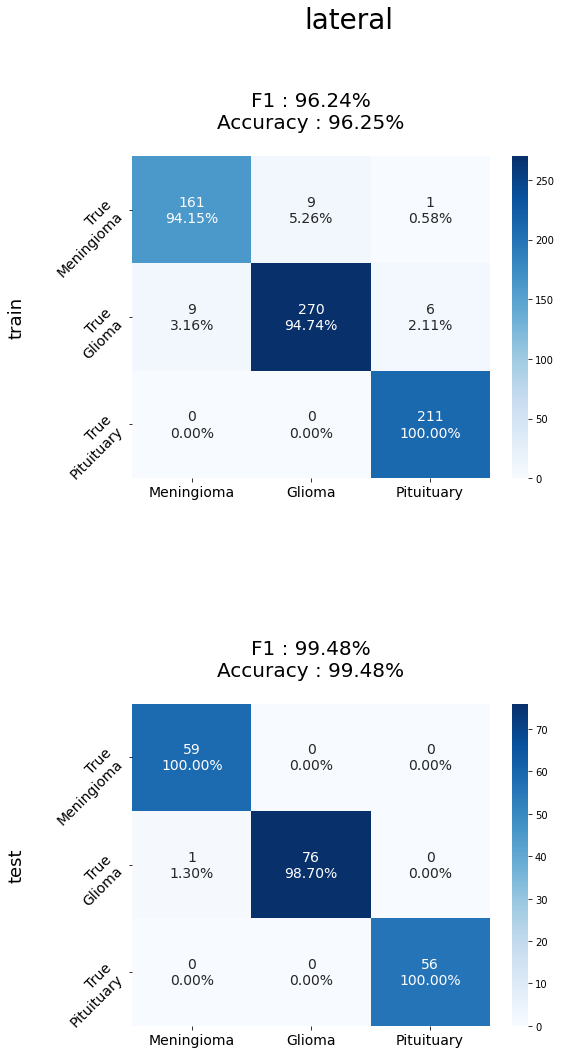

In [207]:
angle = 'lateral'
compare_angles(angle, model_id)

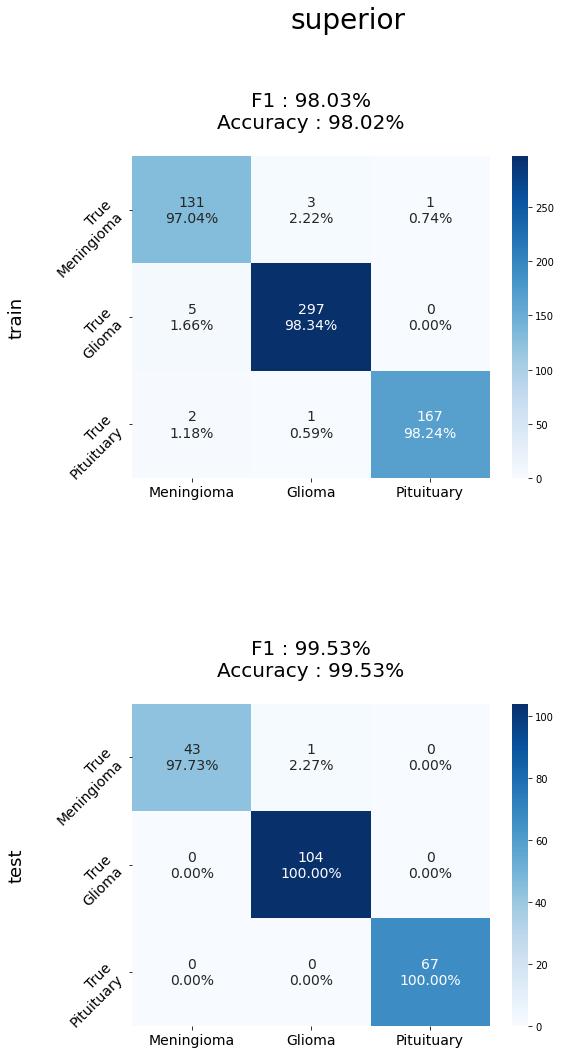

In [208]:
angle = 'superior'
compare_angles(angle, model_id)